In [15]:
from __future__ import absolute_import, division, print_function
from builtins import (
    ascii, bytes, chr, dict, filter, hex, input, int, map,
    next, oct, open, pow, range, round, str, super, zip)

import os
from itertools import cycle
from functools import partial
import random
from math import pi
import json
from copy import deepcopy
from collections import defaultdict

import numpy as np
import pandas as pd
from sklearn.cluster import KMeans

# Imports for working with shapefiles
import pyproj
from shapely.geometry import (shape, 
                              MultiPolygon,
                              Point,
                              MultiPoint, 
                              mapping)
from shapely.ops import (transform, 
                         cascaded_union)
from descartes import PolygonPatch
import fiona
from fiona.crs import from_epsg

# matplotlib imports
import matplotlib.pyplot as plt
import matplotlib.pylab as plb
from matplotlib.colors import to_rgb
from matplotlib import cm
from matplotlib.patches import Polygon
%matplotlib inline

In [2]:
wisc_census_blocks = 'data/block_groups/shapes/tl_2013_55_bg.shp'

project = partial(
    pyproj.transform,
    pyproj.Proj(init='epsg:4326'), 
    pyproj.Proj(init='epsg:3695')
)

In [3]:
poptot_df = pd.read_csv('data/block_groups/pop_tot/DEC_10_SF1_P1_with_ann.csv')
poptot_df = poptot_df[['GEO.id2', 'D001']]
poptot_df.columns = ['geoid', 'poptot']
poptot_df.drop(0, axis=0, inplace=True)
poptot_df.set_index('geoid', inplace=True)

pop18_df = pd.read_csv('data/block_groups/pop18/DEC_10_SF1_P10_with_ann.csv')
pop18_df = pop18_df[['GEO.id2', 'D001', 'D003']]
pop18_df.columns = ['geoid', 'pop18', 'pop18wht']
pop18_df.drop(0, axis=0, inplace=True)
pop18_df.set_index('geoid', inplace=True)

In [4]:
with fiona.open(wisc_census_blocks) as f:
    blocks = [
        {
            'shape': transform(project, shape(block['geometry'])), 
            'geoid': block['properties']['GEOID'],
            'untransformed': shape(block['geometry'])
        }
        for block in f
    ]

In [5]:
for block in blocks:
    block['centroid'] = np.array([coord[0] for coord in block['shape'].centroid.xy])
    block['pop18'] = int(pop18_df.loc[block['geoid']]['pop18'])
    block['pop18wht'] = int(pop18_df.loc[block['geoid']]['pop18wht'])
    block['poptot'] = int(poptot_df.loc[block['geoid']]['poptot'])

In [6]:
coord_array = np.array([block['centroid'] for block in blocks])
weight_array = np.array([block['poptot'] for block in blocks])

In [7]:
model = KMeans(n_clusters=8, max_iter=1e6, n_jobs=-1, tol=1e-11)

In [8]:
labels = model.fit_predict(coord_array)

In [9]:
for label, block in zip(labels, blocks):
    block['label'] = int(label)

In [10]:
districts = [{} for i in range(8)]
for label in range(8):
    districts[label]['shape'] = cascaded_union([block['shape'] for block in blocks if block['label'] == label])
    
    districts[label]['untransformed'] = cascaded_union([
        block['untransformed']
        for block in blocks
        if block['label'] == label
    ])

In [13]:
for i in range(8):
    print(blocks[0]['shape'].distance(districts[i]['shape'].convex_hull))

204530.349718
0.0
187732.81586
158328.766881
382745.096169
69775.7559959
320210.029257
86633.6783978


In [13]:
wisc_pop = np.sum([block['poptot'] for block in blocks])
ideal_dist_pop = wisc_pop/8

for label in range(8):
    _tot_pop = np.sum([block['poptot'] for block in blocks if block['label'] == label])
    districts[label]['poptot'] = _tot_pop
    
    _tot_pop18 = np.sum([block['pop18'] for block in blocks if block['label'] == label])
    districts[label]['pop18'] = _tot_pop18
    
    _tot_pop18wht = np.sum([block['pop18wht'] for block in blocks if block['label'] == label])
    districts[label]['pop18wht'] = _tot_pop18wht
    
    _area = districts[label]['shape'].area/(1000)**2
    _perimeter = districts[label]['shape'].length/1000
    districts[label]['compactness'] = (4*pi*_area/_perimeter**2)
    
    _pop_diff = _tot_pop - ideal_dist_pop
    districts[label]['popdiff'] = _pop_diff/ideal_dist_pop
    
print(ideal_dist_pop, _tot_pop)

710873.25 444261


In [14]:
for i, district in enumerate(districts):
    print('Population of District {}: {}'.format(i, district['poptot']))

Population of District 0: 476630
Population of District 1: 2029343
Population of District 2: 466486
Population of District 3: 355662
Population of District 4: 444261
Population of District 5: 983785
Population of District 6: 134445
Population of District 7: 796374


In [67]:
with fiona.open('data/districts/congressional/Wisconsin_Congressional_Districts.shp') as f:
    current_districts = [
        {
        'shape': transform(project, shape(district['geometry'])),
        'untransformed': shape(district['geometry'])
        }
        for district in f
    ]
    wisconsin = cascaded_union([transform(project, shape(district['geometry'])) for district in f])
    wisc_untrans = cascaded_union([shape(district['geometry']) for district in f])

In [15]:
wisc_untrans.bounds

(-92.8894329062527, 42.49191474914349, -86.76398658736599, 47.08077430717272)

In [68]:
def generate_colors(values, cmap, reference=1):
    _colors = [cmap(value/reference) for value in values]
    
    return _colors

In [69]:
def plot_shapes(
        shapelist, shape_colors, alpha=0.85, fig_file=None,
        center_of_mass_arr=None):
    _patches = [
        PolygonPatch(shape['shape'].intersection(wisconsin))
        for shape in shapelist
    ]
    
    for patch, color in zip(_patches, cycle(shape_colors)):
        patch.set_facecolor(color)
        patch.set_linewidth(1.5)
        patch.set_alpha(alpha)
        
    fig, ax = plt.subplots()
    
    fig.patch.set_alpha(0.0)

    for patch in _patches:
        ax.add_patch(patch)
        
    if center_of_mass_arr is not None:
        ax.plot(center_of_mass_arr[:,0], center_of_mass_arr[:,1])

    ax.relim()
    ax.autoscale_view()
    ax.axis('off')
    ymin, ymax = ax.get_ylim()
    xmin, xmax = ax.get_xlim()
    aspect_ratio = (ymax - ymin)/(xmax - xmin)
    x_size = 20
    fig.set_size_inches((x_size, x_size*aspect_ratio))
    
    if fig_file:
        try:
            fig.savefig(fig_file, bbox_inches='tight')
        except IOError as e:
            raise(e)
            
    return None

In [217]:
hex_colors = [
    '#e41a1c', '#377eb8', '#4daf4a', '#984ea3',
    '#ff7f00', '#ffff33', '#a65628', '#f781bf'
]
district_colors = [to_rgb(color) for color in hex_colors]

kmeans_file = 'images/naive_kmeans_districts.png'
plot_shapes(districts, district_colors, fig_file=kmeans_file)

NameError: global name 'wisconsin' is not defined

In [20]:
crs = from_epsg(4326)
schema = {
    'geometry': 'Polygon',
    'properties': {
        'id': 'int', 'cmpctness': 'float', 'poptot': 'int',
        'pop18': 'int', 'pop18wht': 'int', 'popdiff': 'float'
    }
}
with fiona.open('data/districts/generated/kmeans', 'w', 'ESRI Shapefile', schema, crs=crs) as c:
    for i, district in enumerate(districts):
            c.write({
                'geometry': mapping(district['untransformed'].intersection(wisc_untrans)),
                'properties': {
                    'id': i+1, 
                    'cmpctness': district['compactness'],
                    'poptot': district['poptot'],
                    'pop18': district['pop18'],
                    'pop18wht': district['pop18wht'],
                    'popdiff': district['popdiff']
                }
            })

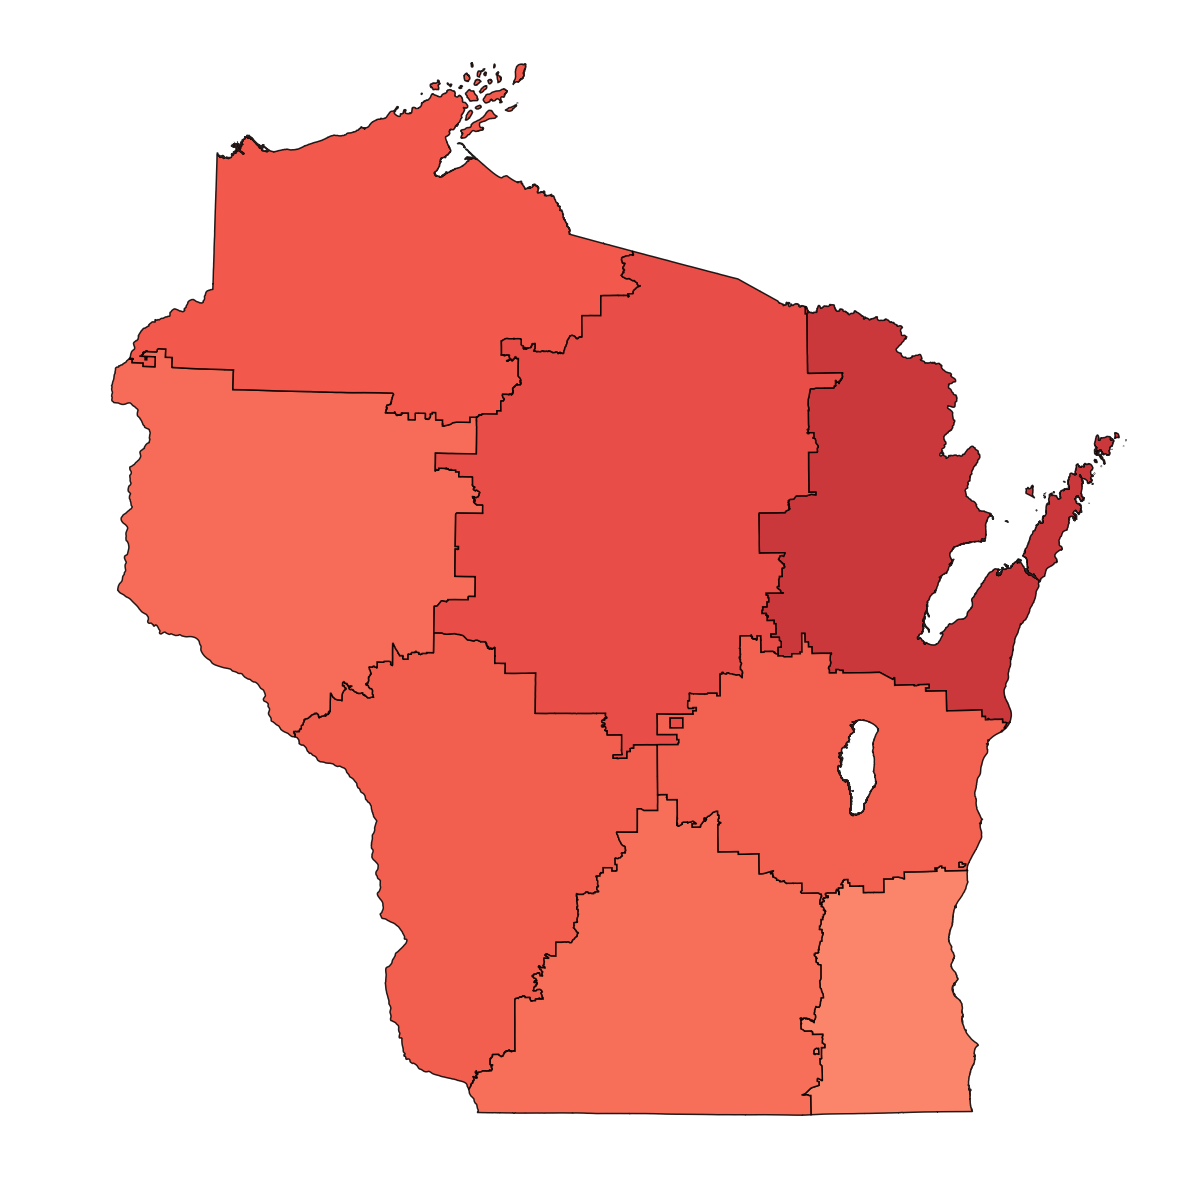

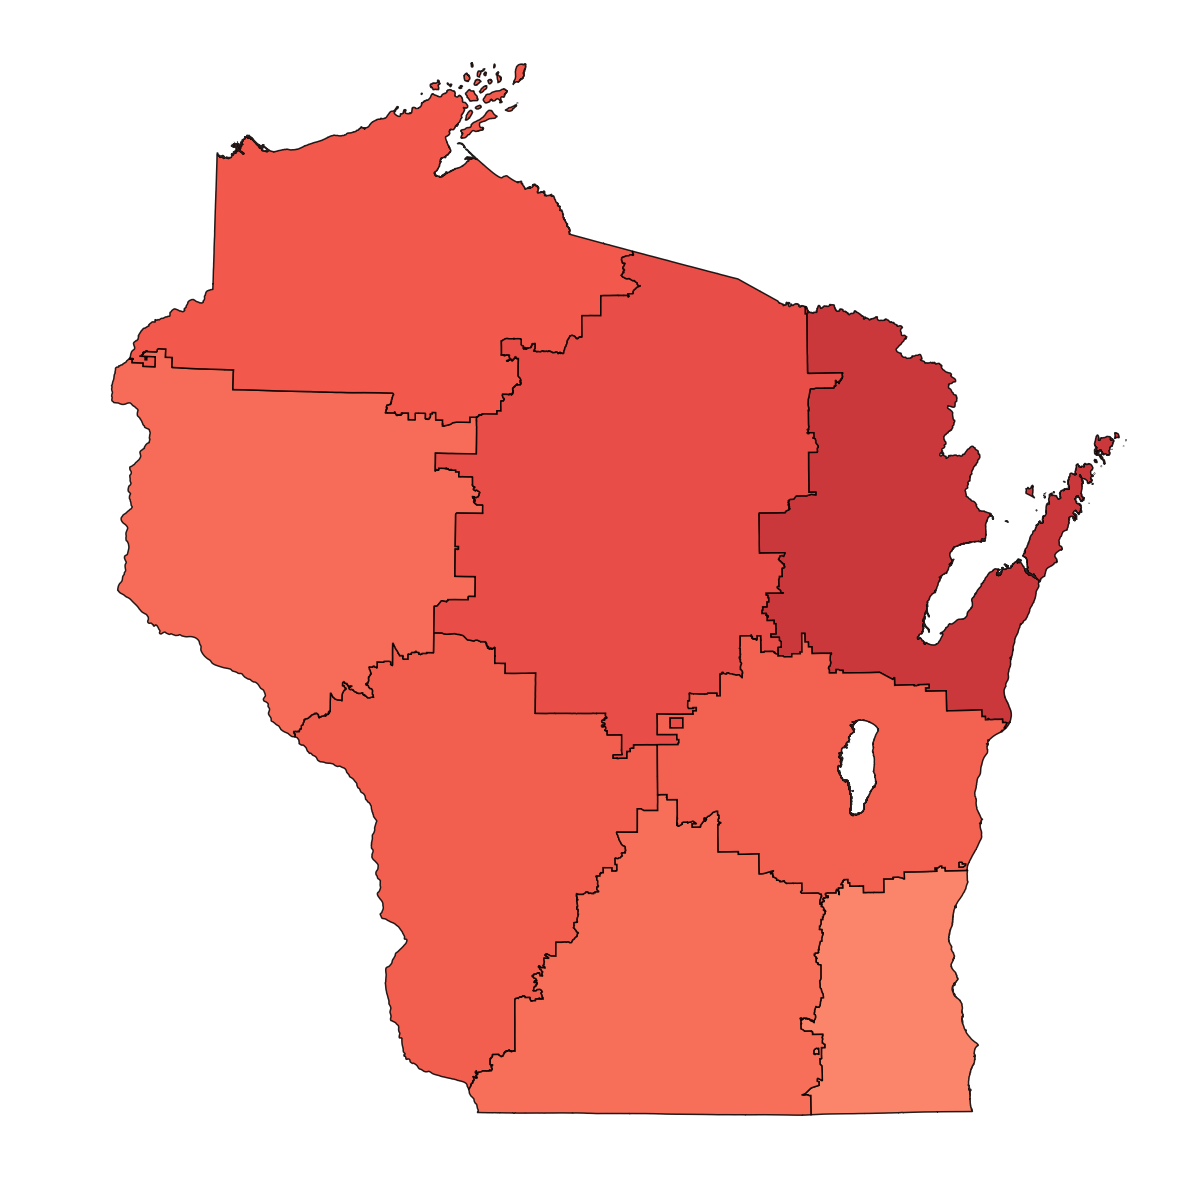

In [21]:
ref_aspect = 1.5
reference = 4*pi*(ref_aspect)/(2*(1+ref_aspect))**2
cmpct_values = [dis['compactness'] for dis in districts]
cmpct_colors = generate_colors(cmpct_values, cm.Reds_r, reference=reference)

plot_shapes(districts, cmpct_colors)

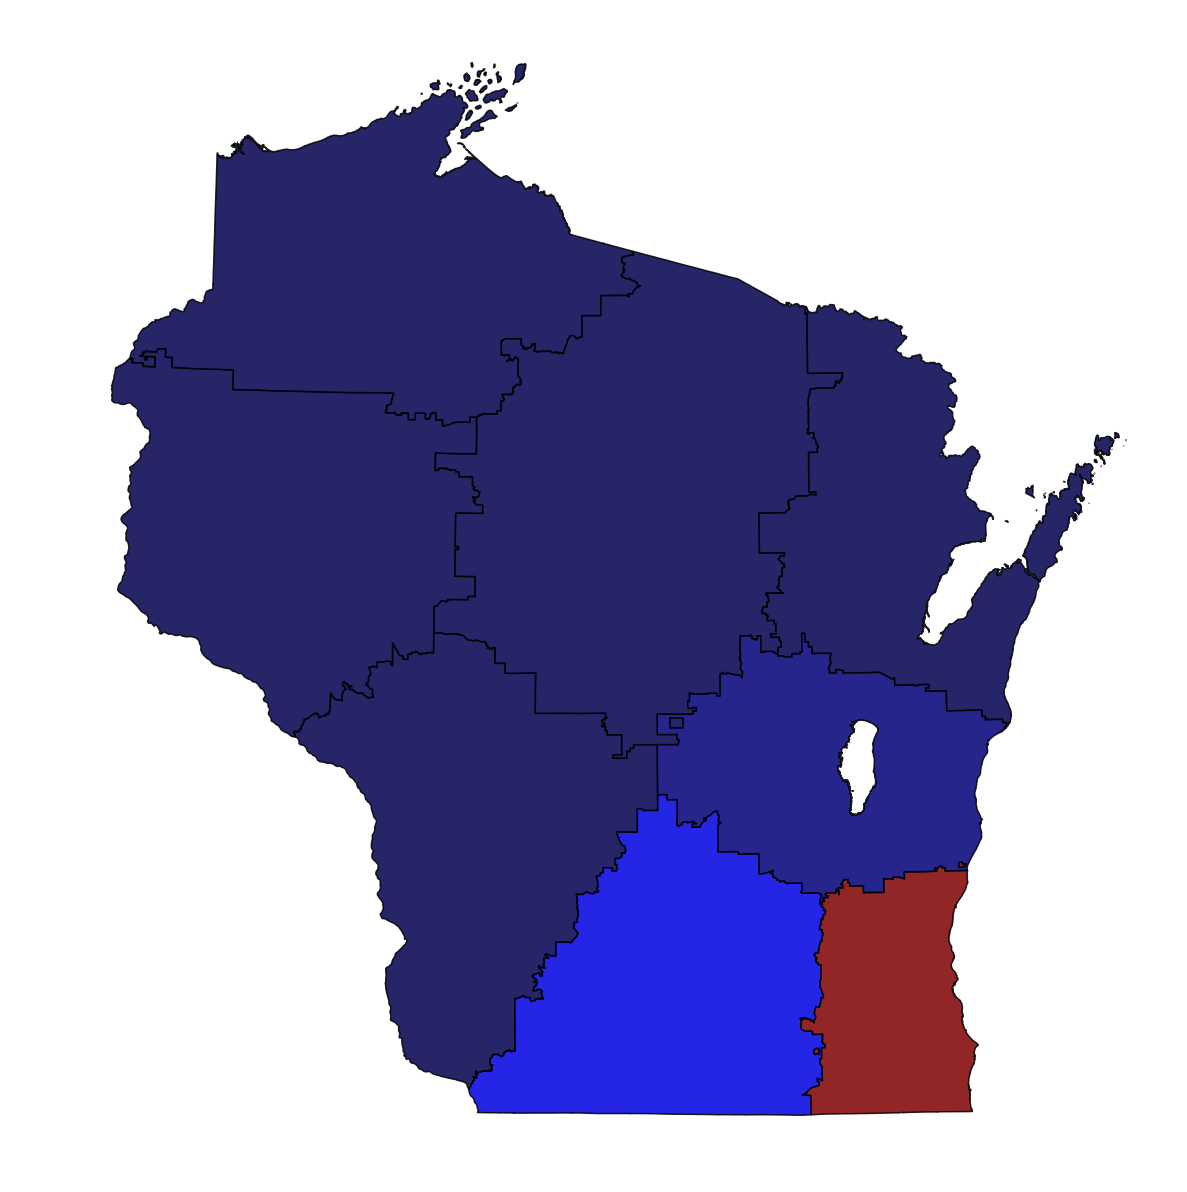

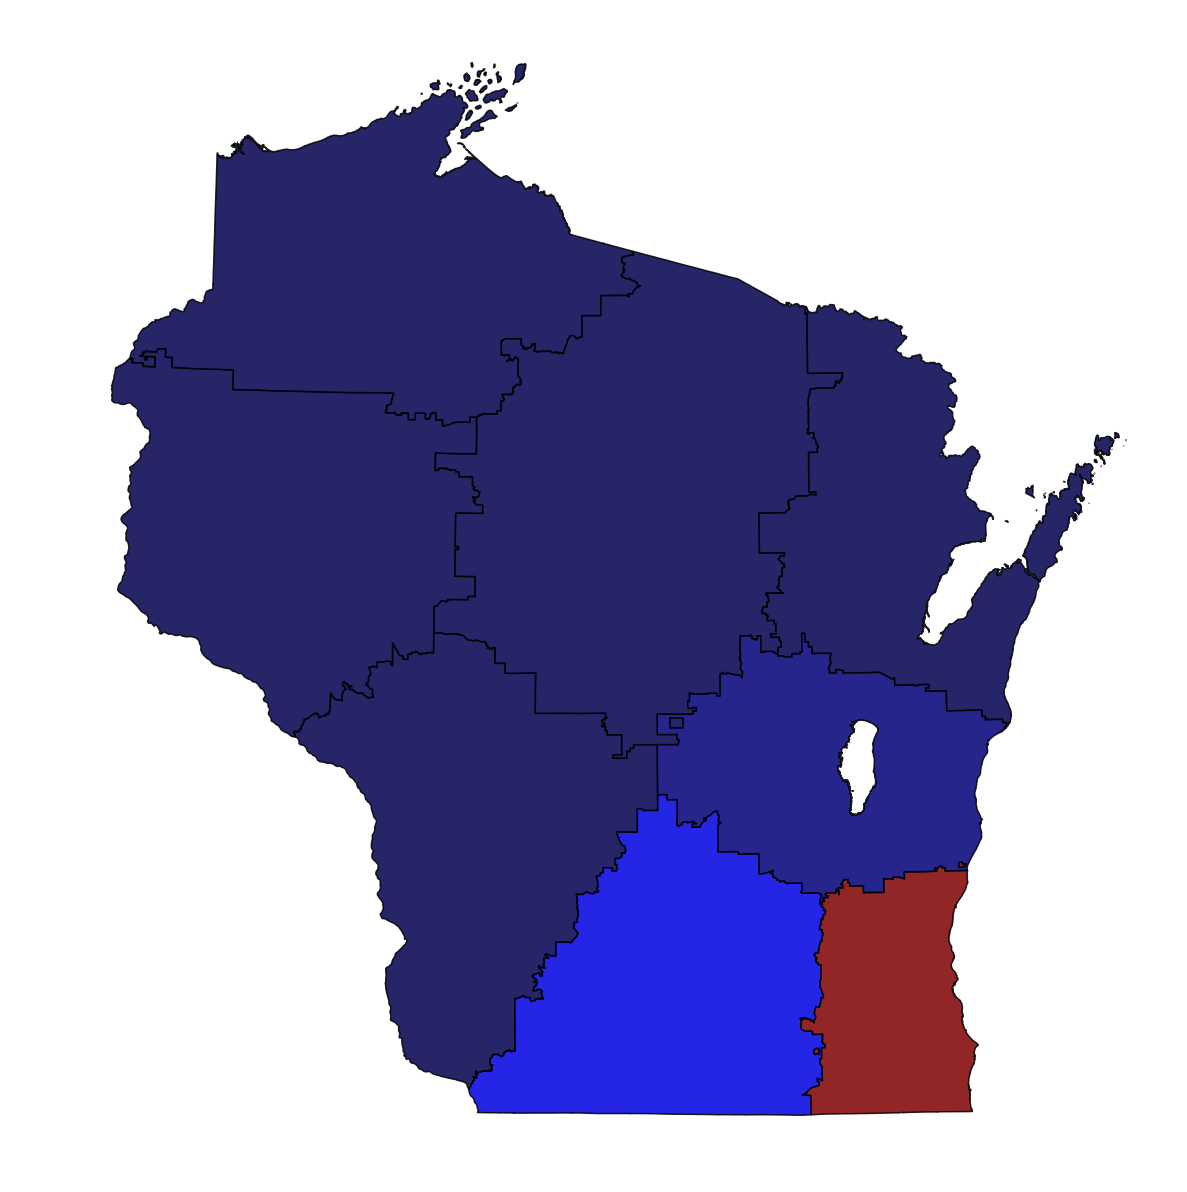

In [23]:
signed_vars = [district['popdiff'] for district in districts]
var_colors = generate_colors(signed_vars, cm.seismic, reference=max(np.abs(signed_vars)))

plot_shapes(districts, var_colors)

In [24]:
with fiona.collection("data/districts/generated/kmeans/kmeans.shp", "r") as source:
    features = [feature for feature in source]
    crs = " ".join("+{}={}".format(key,value) for key, value in source.crs.items())
    
for feature in features:
    feature['geometry'] = mapping(
        shape(feature['geometry']).simplify(4e-3)
    )

In [26]:
my_layer = {
    "type": "FeatureCollection",
    "features": features,
    "crs": {
        "type": "link", 
        "properties": {"href": "kmeans_districts.crs", "type": "proj4"}
    }
}

with open("src/static/geojson/kmeans_districts.json", "w") as f:
    f.write(unicode(json.dumps(my_layer)))
with open("src/static/geojson/kmeans_districts.crs", "w") as f:
    f.write(unicode(crs))

In [197]:
class SameSizeKMeans(object):
    '''K-Means clustering
    
    Parameters
    ----------
    n_clusters : int, optional, default: 8
        The number of clusters to form as well as the number of
        centroids to generate.
    
    weight_tol : float, default: 1e-4
        Fractional tolerance of the 
        
    init_model: KMeans object, default: None
        The initial KMeans model to fit on. Leaving as None
        defaults to KMeans with default parameters except for
        passing the as-specified n_clusters.
        
    save_labels: bool, default: False
        Whether to save labels at each step of the fitting
        process. Setting to True will cause the creation
        
    Attributes
    ----------
    cluster_centers_ : array, [n_clusters, n_features]
        Final coordinates of cluster centers
    
    labels_ :
        Final labels of each point
        
    all_labels_:
        Labels of each point at each step of the fitting
        process. None unless save_labels is set to True.
    
    '''
    
    ORDER_DICT = {
        'largest_first': 'l',
        'smallest_first': 's',
        'l': 'l',
        's': 's',
        'min_v': 'min_v',
        'max_v': 'max_v'
    }
    
    def __init__(self, n_clusters=8, init_model = None,
                 max_iter=100, save_labels=True,
                 metric='l2', distance_array=None):
        self.n_clusters = n_clusters
        if init_model is None:
            self.init_model = KMeans(n_clusters=n_clusters)
        else:
            self.init_model = init_model
        self.init_params = self.init_model.get_params()
        self.save_labels = save_labels
        if save_labels:
            self.all_labels_ = []
        else:
            self.all_labels_ = None
        self.max_iter=max_iter
        self.metric = metric
        self.distance_array = distance_array
    
    def fit(self, X, weights=None, weight_tol=0, order='max_v'):
        
        self._save_fit_params(X, weights, weight_tol, order)
        
        # Assign initial labels from a naive KMeans clustering
        self._fit_naive_KMeans(X)
        
        for step in range(self.max_iter):
            
            print('Starting step ',step)
            
            # Determine the cluster to update on this step, along
            # with its associated info
            _coords, _weights, _label = self._find_cluster(_order)
            _cluster

            # Adjust the determined cluster, and return its new
            # coordinates
            self._adjust_cluster(_coords, _weights, _label,
                                 _score_arr, order, step)
            
            # Update centroids
            self._update_centroids()
            
            if self.save_labels:
                self.all_labels_.append(deepcopy(self.final_labels))
            
            clusters_within_tol = [
                (self.cluster_variance_[label]/
                 self._ideal_cluster_weight < self.weight_tol)
                for label in self._unique_labels
            ]
            if all(clusters_within_tol):
                break
            else:
                print('Clusters still not within specified tolerance.')
    
    def _save_fit_params(self, X, weights, weight_tol, order):
        
        self.X = X
        self.weight_tol = weight_tol
        self.touching_clusters_ = defaultdict(list)
        
        if weights is None:
            self.weights = np.ones(X.shape[0])
        else:
            try:
                assert(weights.shape[0] == X.shape[0])
                self.weights = weights                    
            except AssertionError:
                raise AssertionError('X and weights are not the same length')
        
        self._ideal_cluster_weight = np.sum(self.weights)/self.n_clusters    
    
    def _fit_naive_KMeans(self, X):
        
        # Setup naive KMeans model
        _temp_model = KMeans(**self.init_params)

        # Get labels from KMeans model, and save them if desired
        _temp_labels = _temp_model.fit_predict(X)
        self._unique_labels = np.unique(_temp_labels)
        if self.save_labels:
            self.all_labels_.append(deepcopy(_temp_labels))
        
        self._update_centroids(labels = _temp_labels)
        
        # Save the current labels as the final labels. To be
        # updated as the program progresses.
        self.final_labels = deepcopy(_temp_labels)
            
        return None
    
    def _update_centroids(self, labels = None):
        
        if labels is None:
            _labels = self.final_labels
        else:
            _labels = labels
        
        # Create a dictionary of cluster centers by label
        self.cluster_centers_ = {
            label: np.mean(
                self.X[_labels == label], axis=0)
            for label in self._unique_labels
        }
            
        # Create a dictionary of cluster convex hulls
        self.cluster_hulls_ = {
            label: MultiPoint(
                self.X[_labels == label]).convex_hull
            for label in self._unique_labels
        }
            
        # Create a dictionary of cluster weights
        self.cluster_weights_ = {
            label: np.sum(
                self.weights[_labels == label])
            for label in self._unique_labels
        }
            
        # Create a dictionary of cluster variances
        self.cluster_variance_ = {
            label: abs(
                np.sum(self.weights[_labels == label])
                - self._ideal_cluster_weight)
            for label in self._unique_labels
        }
        
        # Dictionary of each cluster that has lists of clusters
        # that touch it
        for label in self._unique_labels:
            min_cluster_dist = min(
                [
                    self.cluster_hulls_[_label].distance(
                    self.cluster_hulls_[label])
                    for _label in self._unique_labels
                    if _label != label
                ]
            )
            self.touching_clusters_[label] = [
                _label
                for _label in self._unique_labels
                if _label != label
                if (self.cluster_hulls_[_label].distance(
                    self.cluster_hulls_[label])
                    > 4*min_cluster_dist)
            ]
        
        return None
    
    def _get_cluster_info(self, order, step):
        
        _order = self._get_order(order, step)
        
        # Find the coordinates, weights, and label of the cluster
        # determined by order.
        _coords, _weights, _label = self._find_cluster(_order)
        _centroid = self.cluster_centers_[_label]
        
        if _order == 'l':
            _score_arr = None
        elif _order == 's':
            _score_arr = self._score_other_points(
                _coords, _centroid, _label
            )
        elif _order == 'min_v':
            if np.sum(_weights) > self._ideal_cluster_weight:
                _score_arr = None
            else:
                _score_arr = self._score_other_points(
                    _coords, _centroid, _label
                )
        elif _order == 'max_v':
            if np.sum(_weights) > self._ideal_cluster_weight:
                _score_arr = None
            else:
                _score_arr = self._score_other_points(
                    _coords, _centroid, _label
                )
        
        return(_coords, _weights, _label, _score_arr, _centroid)
    
    def _get_order(self, order, step):
        
        try:
            _order = self.ORDER_DICT[order]
        except KeyError:
            raise KeyError(
                'order must be one of: {}'.format(
                    self.ORDER_DICT.keys())
            )
        except TypeError:
            try:
                _order = self.ORDER_DICT[order[step]]
            except KeyError:
                raise KeyError(
                    'order must be one of: {}'.format(
                        self.ORDER_DICT.keys())
                )
            except TypeError:
                raise TypeError('Order must be a string or list of strings.')
                
        return _order
    
    def _find_cluster(self, order):
        '''Finds the next cluster according to order'''
        
        _labels = deepcopy(self.final_labels)
        
        for label in self._unique_labels:
            print('Weight of cluster {} is {}'.format(
                label, np.sum(self.weights[_labels == label])
            ))
        if order == 'l':
            # Find the label of the largest cluster
            _cluster = max(self.cluster_weights_,
                           key=self.cluster_weights_.get)
        elif order == 's':
            # Find the label of the smallest cluster
            _cluster = min(self.cluster_weights_,
                           key=self.cluster_weights_.get)
        elif order == 'min_v':
            # Find the label of the cluster closest to the optimal size
            _cluster = min(self.cluster_variance_,
                           key=self.cluster_variance_.get)
        elif order == 'max_v':
            # Find the label of the cluster farthest from the optimal size
            _cluster = max(self.cluster_variance_,
                           key=self.cluster_variance_.get)
            
        print('Picked cluster',_cluster)
        _net_variance = np.sum(
            [(np.sum(self.weights[_labels == label]) - self._ideal_cluster_weight)**2
             for label in self._unique_labels]
        )
        print('Net variance from ideal weight: ',_net_variance,'\n')
            
        _coords = self.X[_labels == _cluster]
        _weights = self.weights[_labels == _cluster]
        
        return(_coords, _weights, _cluster)
    
    def _update_large_cluster(self, coords, weights, label):
        '''Upgrade cluster given by label if it is bigger than ideal'''
        
        _distance_arr = 
        
        pass
    
    def _update_small_cluster(self, coords, weights, label):
        '''Upgrade cluster given by label if it is bigger than ideal'''
        
        pass
    
    def _adjust_cluster(self, coords, weights, label,
                        score_arr, order, step):
    
        _order = self._get_order(order, step)
        _other_labels = self.touching_clusters_[label]
        _counter = 0
        
        # Check if the cluster has the right total weight by comparing it
        # to the ideal cluster weight and the specified weight tolerance.
        # If it doesn't, adjust it as necessary according to order.
        while (
                abs(np.sum(weights) - self._ideal_cluster_weight)
                / self._ideal_cluster_weight > self.weight_tol):
            _counter += 1
            if _counter %100 == 0:
                print('Swapped',_counter,'points')

            if _order == 'l':
#                 coords, weights = self._update_large_cluster(
#                     self, coords, weights, label)
                coords, weights = self._reassign_farthest(
                    coords, weights, label)
            elif _order == 's':
#                 coords, weights = self._update_small_cluster(
#                     coords, weights, label)
                coords, weights, score_arr = (
                    self._reassign_closest(
                        coords, weights, label, score_arr)
                )
            elif _order == 'min_v':
                if np.sum(weights) > self._ideal_cluster_weight:
#                     coords, weights = self._update_large_cluster(
#                         self, coords, weights, label)
                    coords, weights = self._reassign_farthest(
                        coords, weights, label, _other_labels)
                else:
#                     coords, weights = self._update_small_cluster(
#                         coords, weights, label)
                    coords, weights, score_arr = (
                        self._reassign_closest(
                            coords, weights, label, score_arr)
                    )
            elif _order == 'max_v':
                if np.sum(weights) > self._ideal_cluster_weight:
#                     coords, weights = self._update_large_cluster(
#                         self, coords, weights, label)
                    coords, weights = self._reassign_farthest(
                        coords, weights, label, _other_labels)
                else:
#                     coords, weights = self._update_small_cluster(
#                         coords, weights, label)
                    coords, weights, score_arr = (
                        self._reassign_closest(
                            coords, weights, label, score_arr)
                    )
                    
        self._update_centroids()
        
        return None
    
    def _score_centroids_one_point(self, coords, label, other_labels):
        '''Finds the point that most wants to switch clusters'''
        
        # Get the labels of the clusters that touch label
        _other_labels = other_labels
        
        # Initialize values for comparison
        _current_label = _other_labels[0]
        _current_point = coords[0]
        _min_dist = self.cluster_hulls_[_current_label].distance(
            Point(_current_point)
        )
        
        # Loop through the points in this cluster, and find
        # the distances between it and the convex hulls of
        # each cluster specified by _other_labels. Find the
        # combination with the smallest distance.
        for point in coords:
            for _label in _other_labels:
                _dist_from_pnt_to_hull = (
                    self.cluster_hulls_[_label].distance(
                        Point(point))
                    )
                if _dist_from_pnt_to_hull < _min_dist:
                    _min_dist = _dist_from_pnt_to_hull
                    _current_label = _label
                    _current_point = point
        
        return _current_point, _current_label
    
    def _reassign_farthest(self, coords, weights, label, other_labels):
        
        center_of_mass = np.sum(coords*weights[None,1], axis=0)
        
        _point, _new_cluster = self._score_centroids_one_point(
            coords, label, other_labels
        )
        
        # Reassign the label in the final_label array
        _far_point_ind = np.argmax(
            np.isclose(self.X, _point).all(1))
        self.final_labels[_far_point_ind] = _new_cluster
        
        # Remove the point from the current coordinate
        # and weight array
        _point_mask = np.logical_not(
            np.isclose(coords, _point).all(1))
        _coords = coords[_point_mask]
        _weights = weights[_point_mask]
        
        self._update_centroids()
        
        return(_coords, _weights)
    
    def _score_other_points(self, coords, centroid, label):
        
        # Make a mask for each point in coords that tells us
        # if it's in X
        _coords_masks = [
            np.isclose(self.X, coord).all(1)
            for coord in coords
        ]
        
        # Sum all the masks, and negate the result to obtain
        # a mask for only those points not in coords, then
        # use it to obtain an array of only those points
        _other_points_mask = np.logical_not(
            np.sum(_coords_masks, axis=0).astype(np.bool)
        )
        _other_points = self.X[_other_points_mask]
        
        # Make an array where the first column is the point
        # being considered, and the 2nd column is the distance
        # between that point and the convex hull of the current
        # cluster
        score_arr = np.array([
            [point, self.cluster_hulls_[label].distance(
                Point(point.flatten())
            )]
            for point in _other_points
        ])
        
        return score_arr
    
    def _reassign_closest(
            self, coords, weights, label, score_arr):
        
        # Select points in touching clusters
        
        
        # Select the closest point
        _best_score_row = np.argmin(score_arr[:,1])
        _best_point = score_arr[_best_score_row][0]
                
        # Remove the closest point from score_arr to pass it out
        # of the function
        _score_arr = np.delete(score_arr, (_best_score_row), axis=0)
        
        # Reassign the label in the final_label array, and get
        # the weight of the best point
        _best_point_ind = np.argmax(
            np.isclose(self.X, _best_point).all(1))
        self.final_labels[_best_point_ind] = label
        _best_weight = self.weights[_best_point_ind]
        
        # Add the best point to the _coords and _weights arrays
        _coords = np.vstack((coords, _best_point))
        _weights = np.append(weights, _best_weight)
        
        self._update_centroids()
        
        return(_coords, _weights, _score_arr)
    
    def _calculate_distance(self, coord_arr, point=None):
        
        if coord_arr.ndim == 1:
            _axis = 0
        else:
            _axis = 1
            
        if point is None:
            _point = 0
        else:
            _point = point
        
        if self.metric == 'l2':
            _distances = np.sum(
                (coord_arr - _point)**2, axis=_axis)
        elif self.metric == 'l1':
            _distances = np.sum(
                np.abs(coord_arr - _point), axis=_axis)
        elif self.metric == 'l_inf':
            _distances = np.max(
                np.abs(coord_arr - _point), axis=_axis)
            
        return _distances

def find_nearest(coord_arr, point):
    idx = np.abs(coord_arr - point).argmin()
    return{'dist': coord_arr[idx], 'idx': idx}


In [198]:
max_iter = 10
sskmeans = SameSizeKMeans(n_clusters=8, save_labels=True, max_iter=max_iter)

In [199]:
sskmeans.fit(
    coord_array, weights=weight_array,
    weight_tol=1e-3, order='max_v')
all_labels = sskmeans.all_labels_

Starting step  0
Weight of cluster 0 is 987010
Weight of cluster 1 is 134445
Weight of cluster 2 is 444261
Weight of cluster 3 is 2029343
Weight of cluster 4 is 472572
Weight of cluster 5 is 466307
Weight of cluster 6 is 797179
Weight of cluster 7 is 355869
Picked cluster 3 

Net variance from ideal weight:  2.46804244201e+12
Swapped 100 points
Swapped 200 points
Swapped 300 points
Swapped 400 points
Swapped 500 points
Swapped 600 points
Swapped 700 points
Swapped 800 points
Swapped 900 points
Swapped 1000 points
Swapped 1100 points
Clusters still not within specified tolerance.
Starting step  1
Weight of cluster 0 is 987010
Weight of cluster 1 is 134445
Weight of cluster 2 is 1762622
Weight of cluster 3 is 710982
Weight of cluster 4 is 472572
Weight of cluster 5 is 466307
Weight of cluster 6 is 797179
Weight of cluster 7 is 355869
Picked cluster 2 

Net variance from ideal weight:  1.76477331344e+12
Swapped 100 points
Swapped 200 points
Swapped 300 points
Swapped 400 points
Swapped 50

In [58]:
np.sum(all_labels[1] != all_labels[4])

1720

In [200]:
labels = sskmeans.final_labels
for label, block in zip(labels, blocks):
    block['label'] = int(label)
    block['iscontiguous'] = False

In [201]:
for label in np.unique(labels):
    _label_pop = np.sum(
        [block['poptot'] for block in blocks if block['label'] == label])
    print('Population of district {}: {}'.format(label, _label_pop))

Population of district 0: 710228
Population of district 1: 695359
Population of district 2: 710807
Population of district 3: 821581
Population of district 4: 711033
Population of district 5: 710571
Population of district 6: 615975
Population of district 7: 711432


In [203]:
def cleanup_blocks(blocks, labels):
    
    dist_blocks = {
    label: [block for block in blocks
            if block['label'] == label]
    for label in np.unique(labels)
    }
    
    for label in dist_blocks:
        print(label)
        _blocks = dist_blocks[label]
        for block in _blocks:
            if block['iscontiguous']:
                continue
            for other_block in _blocks:
                if block['geoid'] != other_block['geoid']:
                    if block['shape'].touches(other_block['shape']):
                        block['iscontiguous'] = True
                        other_block['iscontiguous'] = True
                        break
                    else:
                        block['iscontiguous'] = False
    
    for block in blocks:
        votes = defaultdict(int)
        if block['iscontiguous']:
            continue
        for other_block in blocks:
            if other_block['geoid'] == block['geoid']:
                continue
            if other_block['shape'].touches(block['shape']):
                votes[other_block['label']] +=1
        preferred_label = max(votes, key=votes.get)
        block['label'] = preferred_label
        block['iscontiguous'] = True

In [204]:
cleanup_blocks(blocks, labels)

0
1
2
3
4
5
6
7


In [205]:
for block in blocks:
    if not block['iscontiguous']:
        print(block['geoid'])

In [206]:
new_districts = [{} for label in np.unique(labels)]
for i, label in enumerate(np.unique(labels)):
    new_districts[i]['shape'] = cascaded_union(
        [block['shape'] for block in blocks if block['label'] == label]
    )
    
    new_districts[i]['untransformed'] = cascaded_union([
        block['untransformed']
        for block in blocks
        if block['label'] == label
    ])

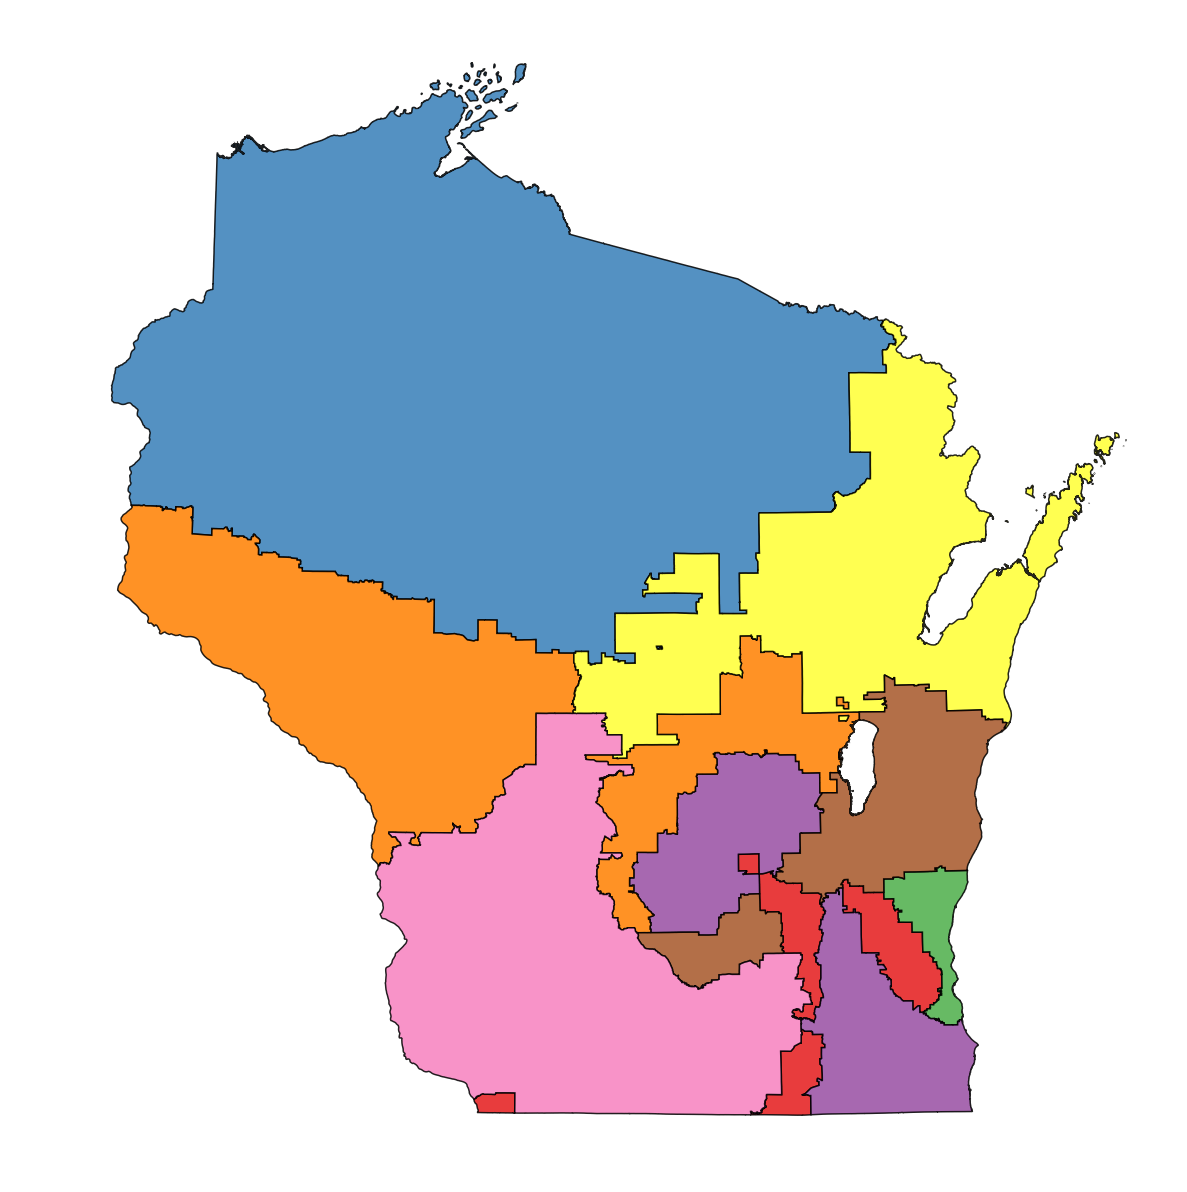

In [207]:
hex_colors = [
    '#e41a1c', '#377eb8', '#4daf4a', '#984ea3',
    '#ff7f00', '#ffff33', '#a65628', '#f781bf'
]
district_colors = [to_rgb(color) for color in hex_colors]

kmeans_file = 'images/samesize_kmeans_test_largest_only.png'
plot_shapes(new_districts, district_colors, fig_file=kmeans_file)

In [208]:
a = np.array([[i,i] for i in range(5)])

In [210]:
b = a + np.array([8,8])

In [211]:
b_hull = MultiPoint(b).convex_hull

In [214]:
@np.vectorize
def get_distance_to_hull(point, hull):
    return Point(point).distance(hull)

In [215]:
c = get_distance_to_hull(a, b_hull)

AssertionError: 

final labels deepcopy
remember to update all clusters!!!!!!!!